# A Simple Convolution Network

- Sobel operator in $x$ direction = 
$
    \begin{bmatrix} 
        -1 & 0 & 1 \\
        -2 & 0 & 2 \\
        -1 & 0 & 1
    \end{bmatrix}
$

- One (input, output) image tuple is given.
- http://docs.opencv.org/3.2.0/d2/d2c/tutorial_sobel_derivatives.html : the kernel for $3\times3$ window may be different inside the funciton; it could be a $5\times5$ mask.

In [1]:
import os
print (os.uname()[1], ' : ', os.getcwd())
import numpy as np
import tensorflow as tf
import cv2 # opencv
from matplotlib import pyplot as plt


titan  :  /disk/2/github/tensorflow-learning


In [2]:
def readimagefiles(filelistname):
    # lines = open(filelistname, 'r').readlines()
    # print (lines)
    i = 0
    ins = []
    outs = []
    in_img = None
    with open(filelistname, 'r') as file:
        for line in file:
            if line[0]!='#':
                i += 1
                print (i, line)
                words = line.split()
                print (words)
                in_img = cv2.imread(words[0],0)
                #print ('# in_img = ', in_img)
                ins.append(in_img)
    return in_img # only one image is needed now.

def do_sobel (gray):
    laplacian = cv2.Laplacian(gray,cv2.CV_64F)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)
    return np.float32(sobelx)

In [3]:
image = readimagefiles('sobel.txt')
#print ('image=', image, image.shape, image.dtype)
sobelx = do_sobel(image)
#print ('sobelx=', sobelx, sobelx.shape, sobelx.dtype)

image = np.float32(image)/255.;
sobelx = np.float32(sobelx)/255.;

print ('image=', image, image.shape, image.dtype)
print ('sobelx=', sobelx, sobelx.shape, sobelx.dtype)

1 sobel/autumn.jpg

['sobel/autumn.jpg']
image= [[ 0.88235295  0.87843138  0.81176472 ...,  0.29411766  0.29019609
   0.29411766]
 [ 0.69411767  0.81176472  0.82745099 ...,  0.26274511  0.27058825
   0.26274511]
 [ 0.28627452  0.48627451  0.627451   ...,  0.24705882  0.23921569
   0.22745098]
 ..., 
 [ 0.38039216  0.38039216  0.39607844 ...,  0.08627451  0.10588235
   0.11372549]
 [ 0.31764707  0.35686275  0.42352942 ...,  0.09803922  0.10588235
   0.08235294]
 [ 0.39215687  0.40000001  0.42745098 ...,  0.20392157  0.18039216
   0.1254902 ]] (240, 320) float32
sobelx= [[ 0.          0.1254902   0.05490196 ...,  0.07058824  0.          0.        ]
 [ 0.          0.53725493  0.18431373 ...,  0.03921569 -0.01960784  0.        ]
 [ 0.          0.45490196  0.45490196 ..., -0.04705882 -0.04705882  0.        ]
 ..., 
 [ 0.          0.16862746  0.16862746 ...,  0.          0.03529412  0.        ]
 [ 0.          0.26274511  0.14117648 ..., -0.03137255 -0.08235294  0.        ]
 [ 0.          0.2

### Now, the goal of the project is to make a convnet produce sobelx given image as an input.


In [4]:
X = tf.placeholder (tf.float32, shape=[None]+list(image.shape)+[1])
Y = tf.placeholder (tf.float32, shape=[None]+list(sobelx.shape)+[1])

image = np.reshape(image, list(image.shape)+[1])
sobelx = np.reshape(sobelx, list(sobelx.shape)+[1])
print ('image.shape=', image.shape, '  [height,width,channel]')

print ('X=', X)
print ('Y=', Y)

# define NN model
filter2d = tf.Variable(tf.random_normal([3,3,1,1], stddev=0.01))
stride = 1
strides = [1,stride,stride,1]
padding = 'SAME'
conv2d = tf.nn.conv2d (X, filter2d, strides, padding, use_cudnn_on_gpu=True)

print ('filter2d=', filter2d)
print ('conv2d=', conv2d)

model = conv2d # goal: output of conv2d == sobel 

image.shape= (240, 320, 1)   [height,width,channel]
X= Tensor("Placeholder:0", shape=(?, 240, 320, 1), dtype=float32)
Y= Tensor("Placeholder_1:0", shape=(?, 240, 320, 1), dtype=float32)
filter2d= Tensor("Variable/read:0", shape=(3, 3, 1, 1), dtype=float32)
conv2d= Tensor("Conv2D:0", shape=(?, 240, 320, 1), dtype=float32)


In [5]:
cost = tf.reduce_mean (tf.square(model - Y))
trainer = tf.train.AdamOptimizer(0.001).minimize(cost)

In [6]:
niter = 10000
step = int(niter/10)
batch_input = np.array( [ image ] )
batch_output = np.array( [sobelx] )
print ('shape i/o= ', batch_input.shape, batch_output.shape)

feed_dict = {X: batch_input, Y: batch_output}

# learing loop
#
ss= tf.Session()
ss.run(tf.global_variables_initializer())
for i in range (niter):
    ss.run (trainer, feed_dict=feed_dict)
    if i%step == 0:
        print ('{}/{}'.format(i,niter), 
               ' cost=', ss.run(cost,feed_dict))
        #outimage = ss.run(model, feed_dict)
        #print (outimage, outimage.shape)
        #disp = np.uint8 (outimage[0,:,:,0]*255.)
        #print (disp, disp.shape)
        #plt.imshow ( disp, cmap='gray' )
        #plt.show()
print ('$ Finished learning')

shape i/o=  (1, 240, 320, 1) (1, 240, 320, 1)
0/10000  cost= 0.217598
1000/10000  cost= 0.0496688
2000/10000  cost= 0.0259309
3000/10000  cost= 0.0240798
4000/10000  cost= 0.0231673
5000/10000  cost= 0.022572
6000/10000  cost= 0.0223464
7000/10000  cost= 0.0223098
8000/10000  cost= 0.0223082
9000/10000  cost= 0.0223082
$ Finished learning


In [7]:
filter_est = ss.run (filter2d)
print ('filter_est = ', filter_est[:,:,0,0])

filter_est =  [[-0.58737153 -0.38748604  0.9542684 ]
 [-1.96865273 -0.06216516  2.06473589]
 [-0.59689188 -0.3337048   0.90891463]]


In [8]:
sobel_pred = ss.run (model, feed_dict)
#disp = np.int8 (sobel_pred[0,:,:,0]*255.)
dispf = sobel_pred[0,:,:,0]
print ('sobel_pred=', dispf)

sobel_pred= [[  2.26507163e+00  -4.86952476e-02   3.60542536e-02 ...,   4.89340648e-02
    1.90552720e-03  -8.38770449e-01]
 [  2.47574043e+00   4.44672465e-01   1.50953203e-01 ...,   3.28186229e-02
   -1.66731626e-02  -1.05213463e+00]
 [  1.53077793e+00   5.24235785e-01   4.52746451e-01 ...,  -4.97687533e-02
   -4.39015813e-02  -9.78623986e-01]
 ..., 
 [  1.20624280e+00   1.37743637e-01   1.30841374e-01 ...,   5.33994613e-03
    3.60328220e-02  -3.55895877e-01]
 [  1.16538155e+00   2.55051404e-01   1.21448591e-01 ...,  -4.83782217e-02
   -8.05857480e-02  -4.69375670e-01]
 [  1.01897490e+00   1.64991230e-01   6.16839714e-03 ...,   5.42660207e-02
   -1.73587292e-01  -4.57033545e-01]]


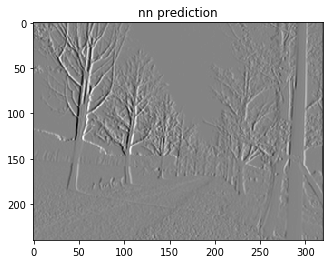

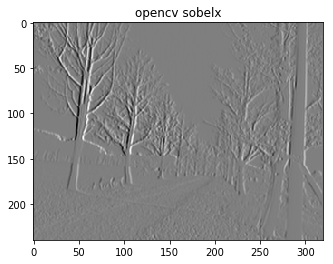

In [13]:
plt.figure()
plt.title ('nn prediction')
plt.imshow (dispf, cmap='gray')
plt.show()
plt.figure()
plt.title ('opencv sobelx')
plt.imshow (sobelx[:,:,0], cmap='gray')
plt.show()

diff: mean = 4.21e-02 std= 1.43e-01 max= 3.13e+00


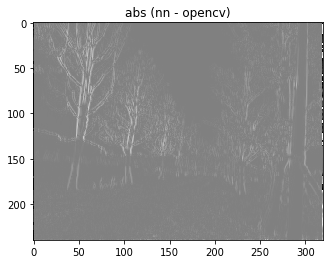

In [23]:
diff = np.abs(dispf - sobelx[:,:,0])
print ('diff: mean = {:.2e} std= {:.2e} max= {:.2e}'.format(np.mean(diff), np.std(diff), np.max(diff)))
#print ('diff = ', diff)

plt.figure()
plt.title ('abs (nn - opencv)')
#diff = np.uint8(diff/np.max(diff) * 128. + 128.)
diff = np.uint8(diff * 128. + 128.)
plt.imshow (diff, cmap='gray')
plt.show()

## The End.